# prepare depth prediction

In [2]:
import sys
sys.path.append("/home/wukailu/latent-nerf/src/ControlNet")

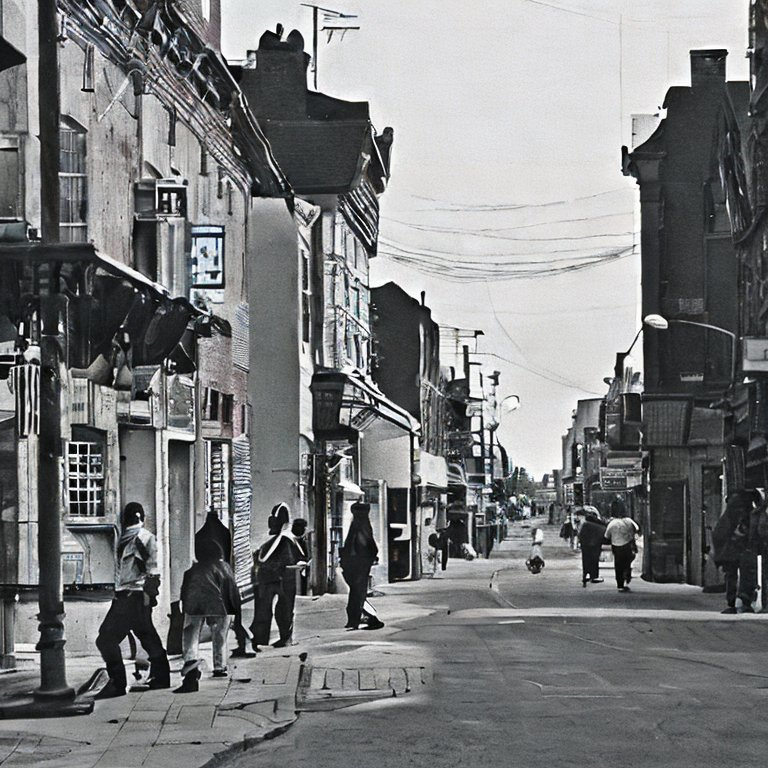

In [3]:
ROOT_PATH = '/home/wukailu/latent-nerf/src/ControlNet/'
IMG_PATH = '/home/wukailu/latent-nerf/src/DPT/input/street.jpg'

from PIL import Image
exp = Image.open(IMG_PATH)
exp

In [4]:
import torch
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector

apply_midas = MidasDetector()
apply_midas_raw = apply_midas.raw_depth

depth_cap = 10  # the maximum predicted depth
disparity_cap = 1.0 / depth_cap
target_disp_mean = 1.0 / (depth_cap / 5)
target_disp_std = target_disp_mean / 2

def pred_disp(input_image, detect_resolution) -> torch.FloatTensor:
    with torch.no_grad():
        input_image = HWC3(input_image)
        detected_map: torch.FloatTensor = apply_midas(resize_image(input_image, detect_resolution))
    return detected_map[0]

def pred_depth(input_image, detect_resolution) -> torch.FloatTensor:
    with torch.no_grad():
        input_image = HWC3(input_image)
        detected_map: torch.FloatTensor = apply_midas_raw(resize_image(input_image, detect_resolution))
        cur_mean = detected_map.mean()
        cur_std = detected_map.std()
        detected_map = ((detected_map-cur_mean)/cur_std * target_disp_std + target_disp_mean).clip(min=disparity_cap)
        detected_map = 1.0 / detected_map
    return detected_map.cpu()

In [5]:
import numpy as np

example_img = np.array(exp)
example_img = example_img[..., :3]
depth = pred_depth(example_img, example_img.shape[0])

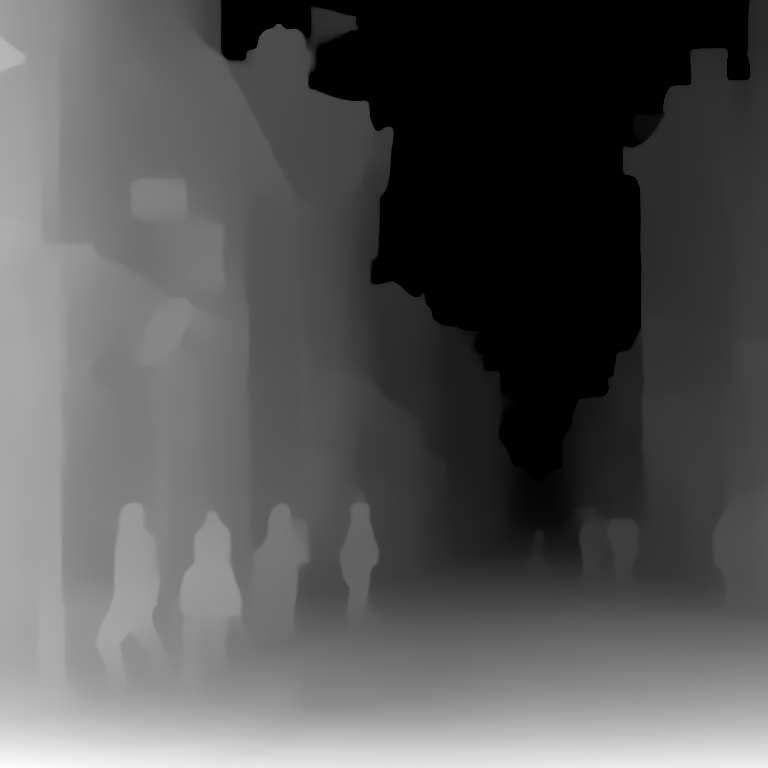

In [6]:
disp = pred_disp(example_img, example_img.shape[0])
Image.fromarray(disp)

# depthmap to point cloud

In [7]:
import torch
import matplotlib.pyplot as plt

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    ray_bundle_to_ray_points,
    NDCMultinomialRaysampler,
)

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [8]:
xy_depth = depth.to(device)  # results from depth prediction above
R, T = look_at_view_transform(5, 0, 0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.01, zfar=depth_cap*2)

In [9]:
# convert the depth maps to point clouds using the grid ray sampler
ray_bundle = NDCMultinomialRaysampler(
        image_width=depth.shape[1],
        image_height=depth.shape[0],
        n_pts_per_ray=1,
        min_depth=0.1,
        max_depth=depth_cap+1,
    )(cameras)
ray_bundle = ray_bundle._replace(lengths = depth[None, ..., None].to(device))
pts_3d = ray_bundle_to_ray_points(ray_bundle)
pts_3d = pts_3d.view(1,-1,3)
features = torch.tensor(example_img).to(device).reshape(1, -1, 3).float()/255.0

# Sanity check
point_cloud = Pointclouds(points=pts_3d, features=features)

In [10]:
# from pytorch3d.io import IO
# IO().save_pointcloud(point_cloud, "/home/wukailu/output_pointcloud.ply")

In [11]:
@torch.no_grad()
def pcd_render(cameras, point_cloud):
    # Define the settings for rasterization and shading. Here we set the output image to be of size
    # 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
    # and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters.
    raster_settings = PointsRasterizationSettings(
        image_size=512,
        radius = 0.003,
        points_per_pixel = 5
    )

    # Create a points renderer by compositing points using an alpha compositor (nearer points
    # are weighted more heavily). See [1] for an explanation.
    rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
    renderer = PointsRenderer(
        rasterizer=rasterizer,
        compositor=AlphaCompositor(background_color=(0.,0.,0.))
    )
    images_1 = renderer(point_cloud)  # c

    renderer = PointsRenderer(
        rasterizer=rasterizer,
        compositor=AlphaCompositor(background_color=(1.,1.,1.))
    )
    images_2 = renderer(point_cloud)  # c + alpha * 1

    alpha = (images_2 - images_1).clip(min=0)
    return images_1, alpha[..., [0]]

In [12]:
# Create camera for viewing the point clouds
R, T = look_at_view_transform(5, 0, 5)
view_cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.01, zfar=depth_cap*2)
images, alphas = pcd_render(view_cameras, point_cloud)

# prepare Inpaint

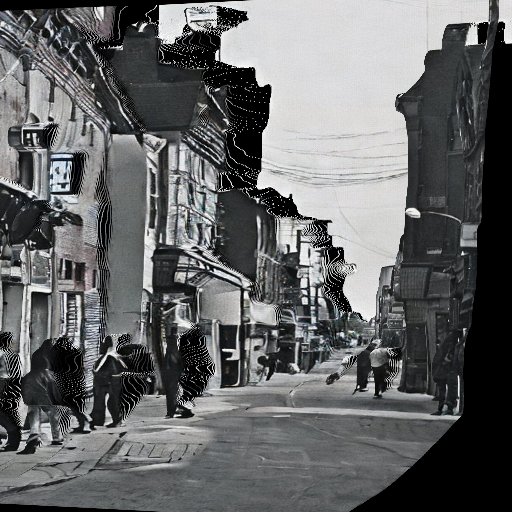

In [31]:
from PIL import Image
image_pil = Image.fromarray((images.cpu().numpy()*255).round().astype(np.uint8)[0])
mask_pil = Image.fromarray(((alphas>0.1).float().expand_as(images).cpu().numpy()*255).round().astype(np.uint8)[0])
image_pil

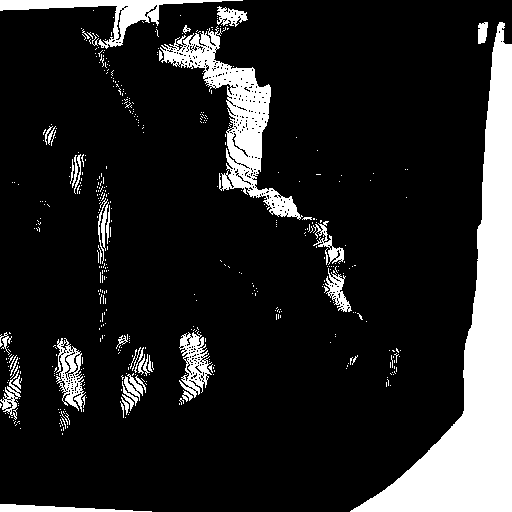

In [71]:
from PIL import Image, ImageFilter
blur_pil = mask_pil.filter(ImageFilter.GaussianBlur(radius = 2))
mask_pil

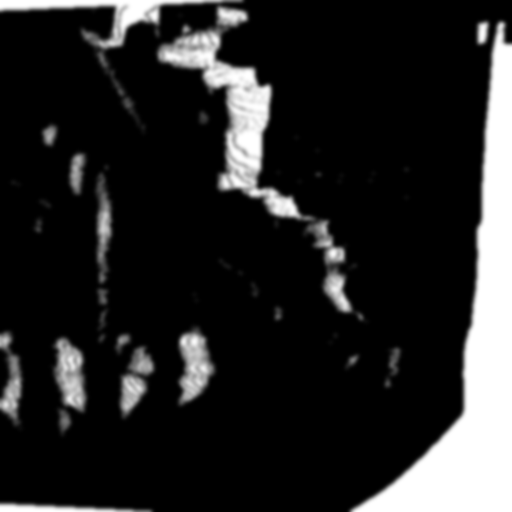

In [72]:
blur_pil

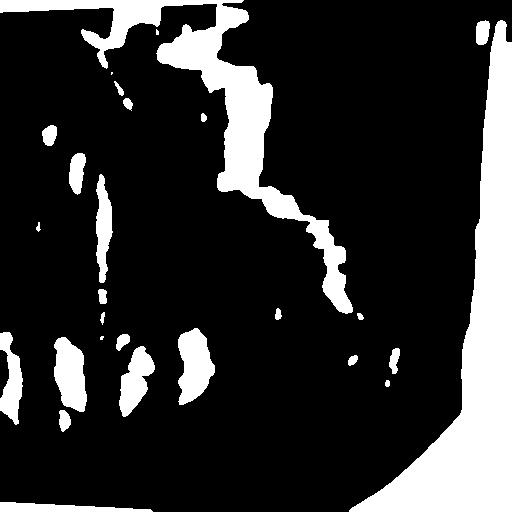

In [73]:
np_blur = np.array(blur_pil)
np_blur[np_blur > 40] = 255
np_blur[np_blur <= 40] = 0
bin_blur_pil = Image.fromarray(np_blur)
bin_blur_pil

In [19]:
import torch
from diffusers import DiffusionPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DiffusionPipeline.from_pretrained(
    # "runwayml/stable-diffusion-inpainting",
    '/home/wukailu/.cache/huggingface/diffusers/cache-runwayml--stable-diffusion-inpainting',
    revision="fp16",
    torch_dtype=torch.float16,
).to(device)

# pipe.save_pretrained('/home/wukailu/.cache/huggingface/diffusers/cache-runwayml--stable-diffusion-inpainting')

In [25]:
def inpaint(init_image, mask, prompt="street", **kwargs):
    with torch.cuda.amp.autocast():
        output = pipe(prompt=prompt, image=init_image, mask_image=mask, num_inference_steps=200, guidance_scale=0, **kwargs)
    return output.images[0]

  0%|          | 0/200 [00:00<?, ?it/s]

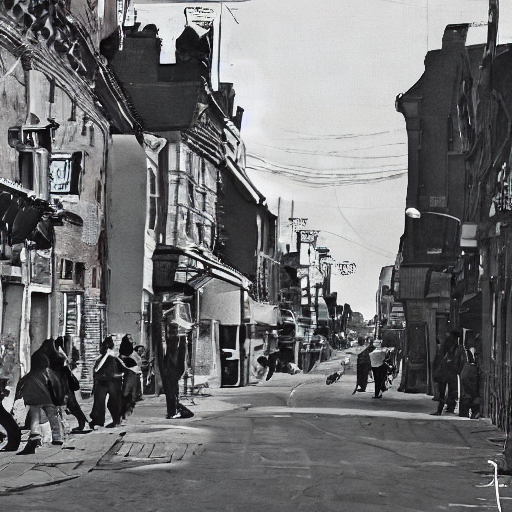

In [74]:
inpaint(image_pil, bin_blur_pil)

  0%|          | 0/200 [00:00<?, ?it/s]

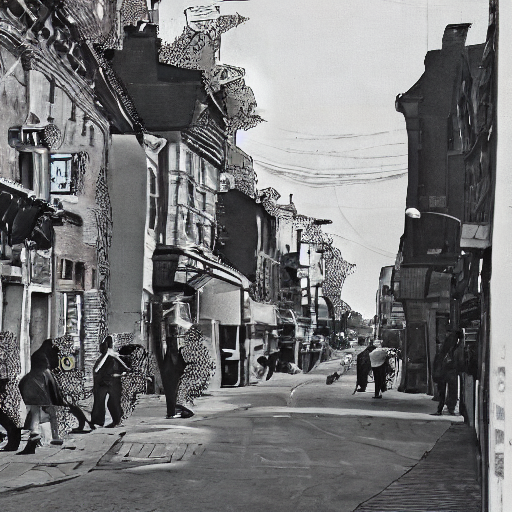

In [75]:
inpaint(image_pil, mask_pil)